In [103]:
# Import packages
import math
import numpy as np
import matplotlib.pyplot as plt

In [104]:
# Define physical properties
length = 8  # m
delta_h = 12  # in.
thickness = 0.5  # mm
D_i = 0.8  # cm
D_o = 1.2  # cm
minor_losses = 25
V_wort = 6  # gal
T_0_wort = 200  # F
T_f_wort = 70  # F
T_city = 50  # F
P_water = 80  # psi
t_max_allowed = 45 * 60

In [105]:
# Define material properties
k_tube = 15  # W/m*K
Nu = 50  # both sides
P_atm = 101325  # Pa
g = 9.81  # m/s^2

In [106]:
# Unit conversion functions
def in_to_m(measurement):
    return 0.0254 * measurement

def mm_to_m(measurement):
    return measurement / 1000

def cm_to_m(measurement):
    return measurement / 100

def gal_to_m3(measurement):
    return measurement * 0.00378541

def m3_to_gal(measurement):
    return measurement / 0.00378541

def f_to_c(measurement):
    return (measurement - 32) * 5 / 9

def c_to_f(measurement):
    return measurement * 9 / 5 + 32

def psi_to_pa(measurement):
    return measurement * 6894.76

def pa_to_psi(measurement):
    return measurement / 6894.76

In [107]:
# Temperature dependent water properties
def get_mu(temp):
    # Equation found here https://resources.saylor.org/wwwresources/archived/site/wp-content/uploads/2011/04/Viscosity.pdf
    mu = 2.414e-5 * 10 ** (247.8/(temp + 273.15 - 140))  # Pa*s
    return mu

def get_rho(temp):
    # Based off the Kell formulation (1975)
    rho = (999.83952 + 16.945176 * temp - 7.9870401e-3 * temp ** 2 - 46.170461e-6 * temp ** 3 + 105.56302e-9 * temp ** 4 - 280.54253e-12 * temp ** 5) / (1 + 16.89785e-3 * temp)  # kg/m^3
    return rho

def get_cp(temp):
    # Based off a fourth order fit of measurements from The Engineering Toolbox
    cp = 4219.4 - 2.9251 * temp + 0.0721 * temp ** 2 - 0.0007 * temp ** 3 + 3e-6 * temp ** 4  # J/kg*K
    return cp

def get_k_fluid(temp):
    # Based off second order fit of measurements from The Engineering Toolbox
    k_fluid = 0.5575 + 0.0022 * temp - 1e-5 * temp ** 2  # W/m*K
    return k_fluid

In [108]:
# Create a pump curve object
class PumpCurve:
    def __init__(self, curve_num):
        # Pump curves from https://www.abset.com/fimett-magdrive/
        if curve_num == 1:
            # Pump 6R
            self.c1 = 1.4143  # m
            self.c2 = -0.0813  # m/lpm
            self.c3 = -0.0013  # m/lpm^2
            self.c4 = -0.0005  # m/lpm^3
            self.maxQ = 10  # lpm
        elif curve_num == 2:
            # Pump 6RZ
            self.c1 = 2.8185
            self.c2 = -0.1978
            self.c3 = -0.0143
            self.c4 = -0.0052
            self.maxQ = 6
        elif curve_num == 3:
            # Pump 10R
            self.c1 = 2.3248
            self.c2 = -0.1071
            self.c3 = -0.0045
            self.c4 = -0.0002
            self.maxQ = 12
        else:
            self.c1 = 1.4143
            self.c2 = -0.0813
            self.c3 = -0.0013
            self.c4 = -0.0005
            self.maxQ = 10
    
    def get_pump_coefficients(self):
        coefficients = [self.c1, self.c2, self.c3, self.c4]
        return coefficients
    
    def get_max_flow(self):
        return self.maxQ

In [109]:
# Initialize the pump curves
pump1 = PumpCurve(1)
pump2 = PumpCurve(2)
pump3 = PumpCurve(3)

In [110]:
# Convert to SI units
delta_h = in_to_m(delta_h)
thickness = mm_to_m(thickness)
D_i = cm_to_m(D_i)
D_o = cm_to_m(D_o)
V_wort = gal_to_m3(V_wort)
T_0_wort = f_to_c(T_0_wort)
T_f_wort = f_to_c(T_f_wort)
T_city = f_to_c(T_city)
P_water = psi_to_pa(P_water)

# Derived values
D_h_out = D_o - (D_i + 2 * thickness)
A_in = math.pi * (D_i ** 2) / 4
A_out = math.pi * ((D_o ** 2) / 4 - ((D_i + 2 * thickness) ** 2) / 4)
rho_city = get_rho(T_city)
mu_city = get_mu(T_city)

In [111]:
def load_default_values():
    # Define physical properties
    length = 8  # m
    delta_h = 12  # in.
    thickness = 0.5  # mm
    D_i = 0.8  # cm
    D_o = 1.2  # cm
    minor_losses = 25
    V_wort = 6  # gal
    T_0_wort = 200  # F
    T_f_wort = 70  # F
    T_city = 50  # F
    P_water = 80  # psi
    t_max_allowed = 45 * 60
    
    # Define material properties
    k_tube = 15  # W/m*K
    Nu = 50  # both sides
    P_atm = 101325  # Pa
    g = 9.81  # m/s^2
    
    # Convert to SI units
    delta_h = in_to_m(delta_h)
    thickness = mm_to_m(thickness)
    D_i = cm_to_m(D_i)
    D_o = cm_to_m(D_o)
    V_wort = gal_to_m3(V_wort)
    T_0_wort = f_to_c(T_0_wort)
    T_f_wort = f_to_c(T_f_wort)
    T_city = f_to_c(T_city)
    P_water = psi_to_pa(P_water)
    
    # Derived values
    D_h_out = D_o - (D_i + 2 * thickness)
    A_in = math.pi * (D_i ** 2) / 4
    A_out = math.pi * ((D_o ** 2) / 4 - ((D_i + 2 * thickness) ** 2) / 4)
    rho_city = get_rho(T_city)
    mu_city = get_mu(T_city)
    return delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g

In [112]:
# Reynolds Number Equation
def reynolds(rho, v, D, mu):
    return rho * v * D / mu

# Friction Factor Equations
def friction_factor(Re):
    return (0.79 * math.log(Re) - 1.64) ** -2

# Calculates the mean flow velocity
def u_m(pressure_grad, hydraulic_diameter, friction_factor, density):
    return math.sqrt(2 * pressure_grad * hydraulic_diameter / (friction_factor * density))

# Calculates the mass flow rate
def m_dot(velocity, area, density):
    return velocity * density * area

In [113]:
# function to calculate flow rate of the city water
def outer_flow(P_outside, f_guess):
    # Assumes that P is given as absolute pressure (not gauge)
    delta_p_city = P_outside - P_atm # Pa
    pressure_gradient = delta_p_city / length  # Pa/m
    
    # Iterate until a solution is found
    converged = False
    i = 0
    v_out = u_m(pressure_gradient, D_h_out, f_guess, rho_city)  # m/s
    print(f"Starting with f_guess = {f_guess}, v_out = {v_out}\n")
    print("Update Loop:")
    while not converged:
        Re_out = reynolds(rho_city, v_out, D_h_out, mu_city)
        f_update = friction_factor(Re_out)
        df = abs(f_update - f_guess)
        if df <= f_guess * 0.1:
            converged = True
            f_out = f_update
            Re_out = reynolds(rho_city, v_out, D_h_out, mu_city)
        else:
            f_guess = f_update
        v_out = u_m(pressure_gradient, D_h_out, f_update, rho_city)  # m/s
        i += 1
        print(f"{i}: f = {f_update}, v = {v_out}")
    
    m_dot_out = m_dot(v_out, A_out, rho_city)
    flow_type = "Turbulent" if Re_out >= 3500 else "Laminar"
    print(f"\nConverged in {i} iterations")
    print(f"Friction Factor: {f_out:.5f}")
    print(f"Reynolds Number: {Re_out:.1f}, flow is {flow_type}")
    print(f"Mean Velocity: {v_out:.2f} m/s")
    print(f"Mass Flow: {m_dot_out:.3f} kg/s")
    
    return m_dot_out, v_out, Re_out, f_out

In [114]:
# Get city water flow properties
m_dot_out, v_out, Re_out, f_out = outer_flow(P_water, 0.04)

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s


In [115]:
# Head Required as a function of Q
def h_req(flow_rate, temperature, delta_z=delta_h, diameter=D_i, L=length, K=minor_losses, grav=g):
    A = math.pi * diameter ** 2
    velocity = flow_rate / A
    rho_in = get_rho(temperature)
    mu_in = get_mu(temperature)
    Re_in = reynolds(rho_in, velocity, diameter, mu_in)
    f_in = friction_factor(Re_in)
    h_required = delta_z + (f_in * L / diameter + K) * (velocity ** 2) / (2 * grav)
    return h_required

# Calculate the intersection of the h_req curve with the pump curve
def intersection(q_set, h_pumps, h_reqs):
    q_prev = 0
    dist_prev = 0
    for i, flow_rate in enumerate(q_set):
        dist = (h_pumps[i] - h_reqs[i])
        if dist < 0:
            d_range = dist_prev - dist
            interp = dist_prev / d_range
            dq = flow_rate - q_prev
            flow = (q_prev + interp * dq) / 60_000
            return flow
        else:
            q_prev = flow_rate
            dist_prev = dist
            
# Plot the H_available from pump vs the H_required
def plot_hreq_vs_pump(temp, pump_curve, show=True):
    pump_coeffs = pump_curve.get_pump_coefficients()
    max_flow = pump_curve.get_max_flow()
    q_vals = np.linspace(0.1, max_flow, 40)
    pump_y = []
    req_y = []
    for q in q_vals:
        y_p = pump_coeffs[0] + q * pump_coeffs[1] + (q ** 2) * pump_coeffs[2] + (q ** 3) * pump_coeffs[3]
        q_m3s = q / 60_000
        y_r = h_req(q_m3s, temp)
        pump_y.append(y_p)
        req_y.append(y_r)
    
    if show:
        plt.plot(q_vals, pump_y, label='H_pump')
        plt.plot(q_vals, req_y, label='H_required')
        plt.legend()
        plt.xlabel('Flow Rate (LPM)')
        plt.ylabel('Head (m)')
        plt.title(f'Pump vs Head at {temp:.1f} C')
        plt.show()
    
    return intersection(q_vals, pump_y, req_y)

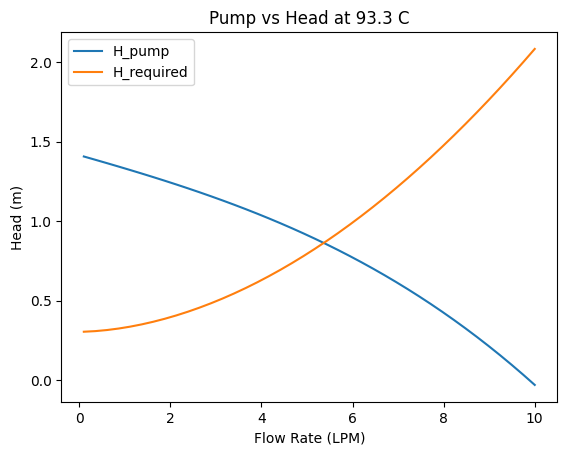

Flow Rate (inner): 0.000089 m^3/s (5.37 LPM)
Mean Velocity: 1.78 m/s
Mass Flow: 0.086


In [116]:
# plot the head curves and calculate flow rate of inner stream
rho_in_0 = get_rho(T_0_wort)
inner_flow = plot_hreq_vs_pump(T_0_wort, pump1)
v_in = inner_flow / A_in
m_dot_in = inner_flow * rho_in_0
print(f"Flow Rate (inner): {inner_flow:.6f} m^3/s ({(inner_flow * 60_000):.2f} LPM)")
print(f"Mean Velocity: {v_in:.2f} m/s")
print(f"Mass Flow: {m_dot_in:.3f}")

In [117]:
# Get convection coefficient using Nu
def convection_coefficient(nusselt, k_fluid, D):
    return nusselt * k_fluid / D

# get total thermal resistance - return UA
def thermal_resistance(d_in, t_tube, L, nusselt, k_tube, temperature):
    # Calculate values for the inside
    A_in_ht = math.pi * d_in * L
    k_in = get_k_fluid(temperature)
    h_in = convection_coefficient(nusselt, k_in, d_in)
    
    # Calculate values for the outside
    A_out_ht = math.pi * (d_in + 2 * t_tube) * L
    k_out = get_k_fluid(T_city)
    h_out = convection_coefficient(nusselt, k_out, (d_in + 2 * t_tube))
    
    R_tot = 1 / (h_in * A_in_ht) + math.log((d_in + 2 * t_tube) / d_in) / (2 * math.pi * k_tube * L) + 1 / (h_out * A_out_ht)
    UA = 1 / R_tot
    return UA

def get_C(temp, m_dot):
    cp = get_cp(temp)
    return cp * m_dot

def epsilon_ntu(UA_calc, Cmin, Cr):
    NTU = UA_calc/Cmin
    if Cr < 1:
        epsilon_calc = (1 - math.exp(-NTU * (1 - Cr))) / (1 - Cr * math.exp(-NTU * (1 - Cr)))
    else:
        epsilon_calc = NTU / (1 + NTU)
    return epsilon_calc, NTU

def get_q(Cmin, T_hot_in, T_cold_in, eps):
    delta_T = T_hot_in - T_cold_in
    return Cmin * delta_T * eps

def bulk_temperature_change(heat_rate_calculated, timestep, density, cp, volume=V_wort):
    return -heat_rate_calculated * timestep / (density * volume * cp)

In [118]:
def heat_transfer_loop(delta_t, outer_mass_flow, pump):
    # Heat transfer calculations and bulk fluid temperature updates
    T_wort = T_0_wort
    time = 0
    plot_times = []
    hot_temps_in = []
    hot_temps_out = []
    cold_temps_out = []
    wort_temps = []
    heat_rates = []
    print("Iterative Calculations\n")
    
    # Iterate until the bulk is at the desired temperature
    while T_wort > T_f_wort:
        print(f"time: {time} s")
        # Append to plot lists
        plot_times.append(time)
        hot_temps_in.append(T_wort)
        wort_temps.append(T_wort)
        
        # Get updated fluid properties
        rho_in = get_rho(T_wort)
        mu_in = get_mu(T_wort)
        cp_in = get_cp(T_wort)
        k_in = get_k_fluid(T_wort)
        
        # Get flow rate of wort
        inner_flow = plot_hreq_vs_pump(T_wort, pump, False)
        m_dot_in = inner_flow * rho_in
        print(f"Mass flow (inner): {m_dot_in:.4f} kg/s")
        print(f"Mass flow (outer): {outer_mass_flow:.4f} kg/s")
        
        # Heat transfer parameters
        C_in = get_C(T_wort, m_dot_in)
        C_out = get_C(T_city, outer_mass_flow)
        C_min = min(C_in, C_out)
        C_max = max(C_in, C_out)
        C_r = C_min / C_max
        
        # Heat transfer calculations
        UA = thermal_resistance(D_i, thickness, length, Nu, k_tube, T_wort)
        epsilon, _ = epsilon_ntu(UA, C_min, C_r)
        print(f"Epsilon: {epsilon:.5f}")
        heat_rate = get_q(C_min, T_wort, T_city, epsilon)
        print(f"Heat rate: {heat_rate:.2f} W")
        heat_rates.append(heat_rate)
        
        # Temperature calculations
        T_hot_out = - (heat_rate / C_in - T_wort)
        print(f"T_hot_out: {T_hot_out:.1f} C")
        hot_temps_out.append(T_hot_out)
        T_cold_out = (heat_rate / C_out + T_city)
        print(f"T_cold_out: {T_cold_out:.1f} C")
        cold_temps_out.append(T_cold_out)
        
        # Calculate temperature change for the bulk
        delta_T_wort = bulk_temperature_change(heat_rate, delta_t, rho_in, cp_in)
        T_wort = T_wort + delta_T_wort
        print(f"T_wort: {T_wort:.1f} C\n")
        time += delta_t
    
    wort_temps.append(T_wort)
    T_wort_F = c_to_f(T_wort)
    print(f"Cooled to {T_wort:.1f} C ({T_wort_F:.1f} F) in {time} seconds ({(time / 60):.2f} minutes)")
    
    # Final Values
    water_used = time * outer_mass_flow
    water_used_gal = m3_to_gal(water_used / rho_city) 
    print(f"Total Time Required: {time} s ({(time / 60):.2f} minutes)")
    print(f"Water Used: {water_used_gal:.3f} gallons")
    
    return plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used_gal, heat_rates

def plot_stream_temps(times, hot_in, hot_out, cold_out, wort, qs, time_final):
    fig, ax1 = plt.subplots(figsize=(9,6))

    # Plot stream temperatures
    ax1.plot(times, hot_in, label="Hot-in")
    ax1.plot(times, hot_out, label="Hot-out")
    ax1.plot(times, cold_out, label="Cold-out")

    # Plot q on its own axis
    ax2 = ax1.twinx()
    ax2.plot(times, qs, label="q", color='r', linestyle='dashdot')

    # Plot temperature in the wort
    plot_times.append(time_final)
    ax1.plot(times, wort, label="Bulk Temperature", linestyle="--")

    # Set axis labels
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("Temperature (C)")
    ax2.set_ylabel("q (W)", color='r')
    ax2.tick_params('y', colors='r')

    # Make legend and show plot
    handles, labels = ax1.get_legend_handles_labels()
    all_handles = handles + ax2.get_legend_handles_labels()[0]
    all_labels = labels + ax2.get_legend_handles_labels()[1]
    ax1.legend(all_handles, all_labels, loc='upper right')
    plt.show()

def plot_wort_temps(plot_times, wort_temps, labels):
    for i in range(len(wort_temps)):
        plt.plot(plot_times[i], wort_temps[i], label=labels[i])
    plt.xlabel("time (s)")
    plt.ylabel("Temperature (C)")
    plt.title("Bulk Fluid Temperature vs Time")
    plt.legend()
    plt.show()
    
def plot_q(plot_times, q):
    plt.plot(plot_times, q)
    plt.xlabel("time (s)")
    plt.ylabel("q (W)")
    plt.show()

Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56033
Heat rate: 17014.95 W
T_hot_out: 46.6 C
T_cold_out: 36.3 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56038
Heat rate: 16633.25 W
T_hot_out: 45.8 C
T_cold_out: 35.7 C
T_wort: 89.7 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56041
Heat rate: 16260.23 W
T_hot_out: 45.0 C
T_cold_out: 35.1 C
T_wort: 87.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15895.69 W
T_hot_out: 44.3 C
T_cold_out: 34.5 C
T_wort: 86.2 C

time: 40 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15539.43 W
T_hot_out: 43.5 C
T_cold_out: 34.0 C
T_wort: 84.6 C

time: 50 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15191.29 W
T_hot_out: 42.8 C
T_cold_out: 33.5 C
T_w

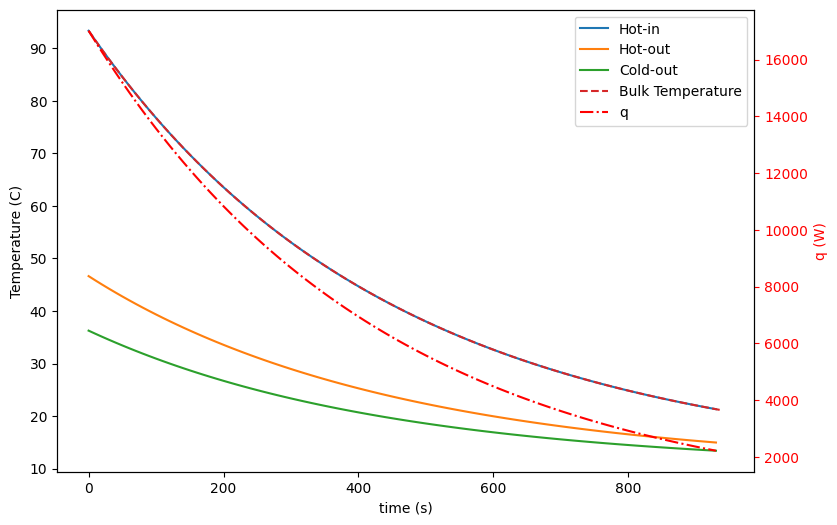

In [119]:
# Run heat transfer and plotting functions
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)
plot_times.append(time)

## Running an Optimization for Pump 6R

For P_city = 206842.8 Pa
Starting with f_guess = 0.04, v_out = 1.4068965748281952

Update Loop:
1: f = 0.04437025860377783, v = 1.3358146066956067
2: f = 0.045145881030793256, v = 1.3242900060462635

Converged in 2 iterations
Friction Factor: 0.04515
Reynolds Number: 3082.3, flow is Laminar
Mean Velocity: 1.32 m/s
Mass Flow: 0.065 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61401
Heat rate: 14064.21 W
T_hot_out: 54.7 C
T_cold_out: 61.2 C
T_wort: 91.8 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61386
Heat rate: 13804.46 W
T_hot_out: 53.9 C
T_cold_out: 60.2 C
T_wort: 90.3 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61372
Heat rate: 13549.56 W
T_hot_out: 53.1 C
T_cold_out: 59.3 C
T_wort: 88.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61356
Heat rate: 13299.42 W
T_hot_out: 52.3 C
T_cold_out: 58

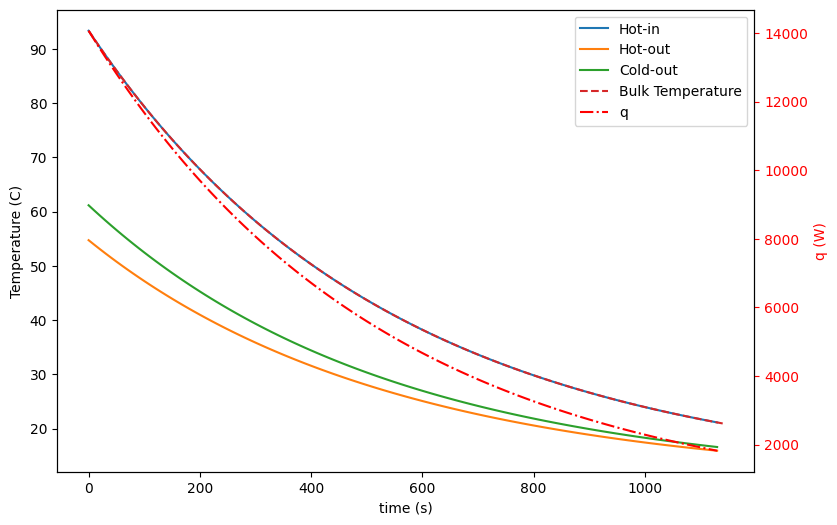

For P_city = 344738.0 Pa
Starting with f_guess = 0.04, v_out = 2.1368360055460496

Update Loop:
1: f = 0.03878743825891564, v = 2.1699795443672074

Converged in 1 iterations
Friction Factor: 0.03879
Reynolds Number: 4930.7, flow is Turbulent
Mean Velocity: 2.17 m/s
Mass Flow: 0.107 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1073 kg/s
Epsilon: 0.52773
Heat rate: 16025.05 W
T_hot_out: 49.4 C
T_cold_out: 45.6 C
T_wort: 91.6 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1073 kg/s
Epsilon: 0.52779
Heat rate: 15686.91 W
T_hot_out: 48.5 C
T_cold_out: 44.8 C
T_wort: 89.9 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1073 kg/s
Epsilon: 0.52783
Heat rate: 15355.98 W
T_hot_out: 47.7 C
T_cold_out: 44.1 C
T_wort: 88.2 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1073 kg/s
Epsilon: 0.52787
Heat rate: 15032.12 W
T_hot_out: 46.9 C
T_cold_out: 43.4 C
T_wort: 86.6 C

time: 40 s
Mass flow (inner):

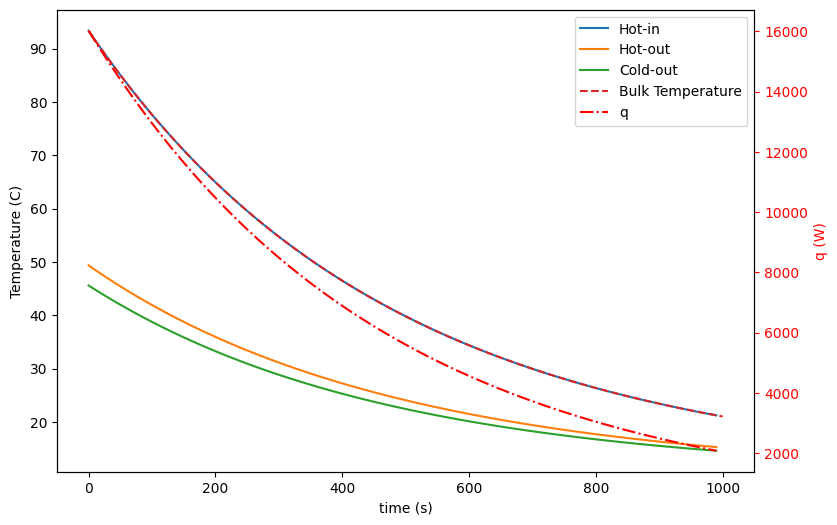

For P_city = 482633.2 Pa
Starting with f_guess = 0.04, v_out = 2.6744678455596893

Update Loop:
1: f = 0.03621426639812554, v = 2.8107843740863356

Converged in 1 iterations
Friction Factor: 0.03621
Reynolds Number: 6171.2, flow is Turbulent
Mean Velocity: 2.81 m/s
Mass Flow: 0.139 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1390 kg/s
Epsilon: 0.55204
Heat rate: 16763.13 W
T_hot_out: 47.3 C
T_cold_out: 38.7 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1390 kg/s
Epsilon: 0.55209
Heat rate: 16392.77 W
T_hot_out: 46.5 C
T_cold_out: 38.1 C
T_wort: 89.8 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1390 kg/s
Epsilon: 0.55212
Heat rate: 16030.69 W
T_hot_out: 45.7 C
T_cold_out: 37.5 C
T_wort: 88.0 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1390 kg/s
Epsilon: 0.55215
Heat rate: 15676.72 W
T_hot_out: 44.9 C
T_cold_out: 36.9 C
T_wort: 86.3 C

time: 40 s
Mass flow (inner):

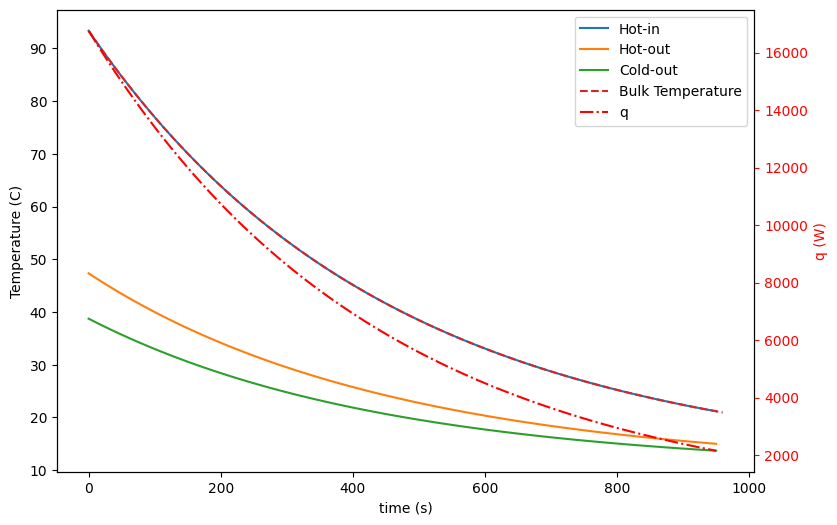

For P_city = 551580.8 Pa
Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56033
Heat rate: 17014.95 W
T_hot_out: 46.6 C
T_cold_out: 36.3 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56038
Heat rate: 16633.25 W
T_hot_out: 45.8 C
T_cold_out: 35.7 C
T_wort: 89.7 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56041
Heat rate: 16260.23 W
T_hot_out: 45.0 C
T_cold_out: 35.1 C
T_wort: 87.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15895.69 W
T_hot_out: 44.3 C
T_cold_out: 34

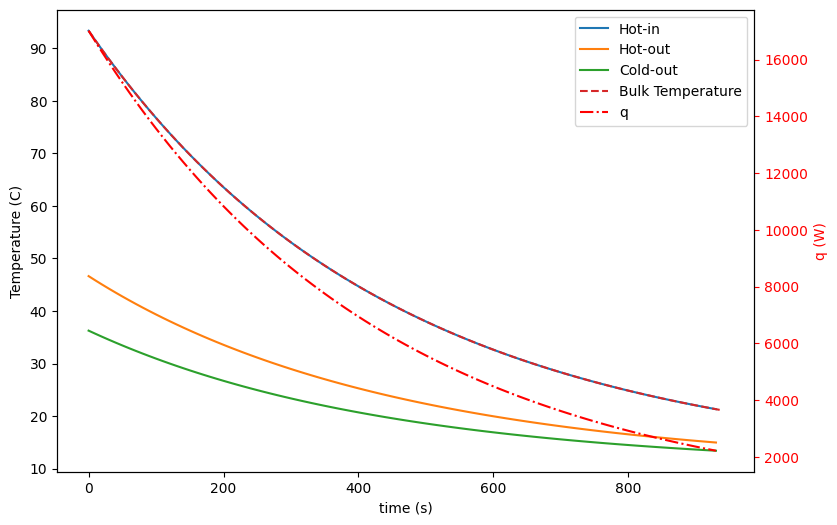

For P_city = 689476.0 Pa
Starting with f_guess = 0.04, v_out = 3.3215724394380923

Update Loop:
1: f = 0.033965295698418926, v = 3.6045912492319174
2: f = 0.033170780075073326, v = 3.647504879251705

Converged in 2 iterations
Friction Factor: 0.03317
Reynolds Number: 8317.5, flow is Turbulent
Mean Velocity: 3.65 m/s
Mass Flow: 0.180 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1804 kg/s
Epsilon: 0.57124
Heat rate: 17346.32 W
T_hot_out: 45.7 C
T_cold_out: 32.9 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1804 kg/s
Epsilon: 0.57129
Heat rate: 16949.46 W
T_hot_out: 44.9 C
T_cold_out: 32.4 C
T_wort: 89.6 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1804 kg/s
Epsilon: 0.57132
Heat rate: 16561.79 W
T_hot_out: 44.1 C
T_cold_out: 31.9 C
T_wort: 87.8 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1804 kg/s
Epsilon: 0.57133
Heat rate: 16183.11 W
T_hot_out: 43.4 C
T_cold_out: 

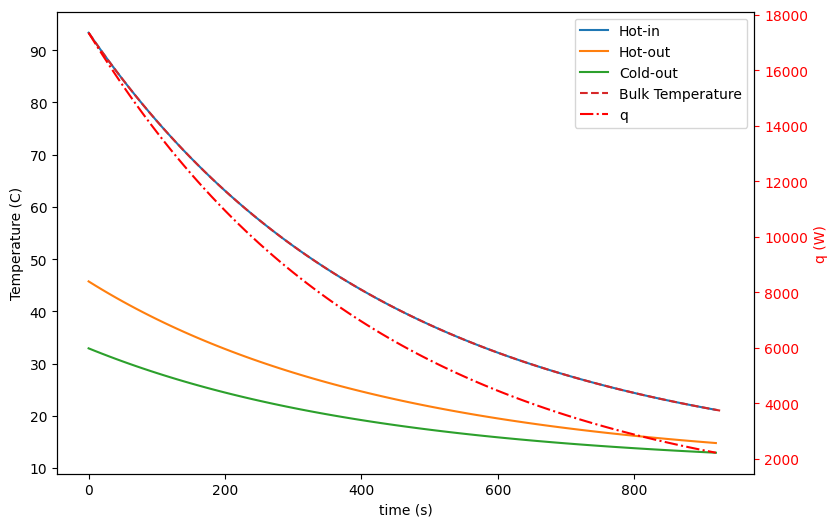


Least Water: 19.73 gal (P=30.00 psi), cooled in 19.00 min


In [120]:
# Vary the pressure of the city water
P_vals = [30, 50, 70, 80, 100]
P_vals_m3 = []
for pressure in P_vals:
    P_vals_m3.append(psi_to_pa(pressure))

water_used = []
time_taken = []
wort_temp_plots = []
wort_time_plots = []
best_performer = math.inf
best_performer_pressure = 0
best_performer_time = 0
for city_pressure in P_vals_m3:
    print(f"For P_city = {city_pressure:.1f} Pa")
    m_dot_outer, _, _, _ = outer_flow(city_pressure, 0.04)
    plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used_gallons, q = heat_transfer_loop(10, m_dot_outer, pump1)
    plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)
    plot_times.append(time)
    wort_temp_plots.append(wort_temps)
    wort_time_plots.append(plot_times)
    water_used.append(water_used_gallons)
    time_taken.append(time)
    if water_used_gallons < best_performer and time <= t_max_allowed:
        best_performer = water_used_gallons
        best_performer_pressure = city_pressure = city_pressure
        best_performer_time = time
        
print(f"\nLeast Water: {best_performer:.2f} gal (P={pa_to_psi(best_performer_pressure):.2f} psi), cooled in {(best_performer_time / 60):.2f} min")

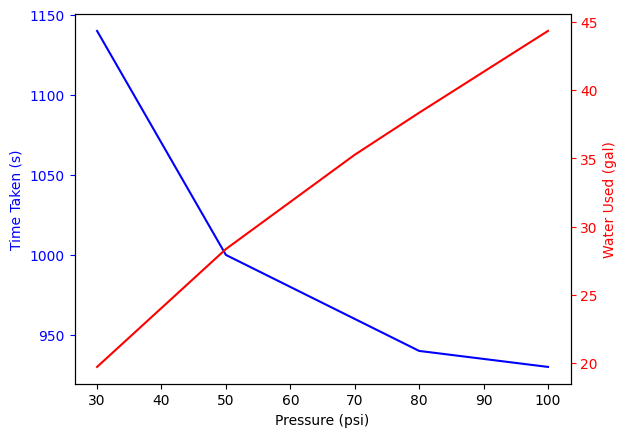

In [121]:
# Creating a figure and a single axis
fig, ax1 = plt.subplots()

# Plotting the first line (time taken vs pressure)
ax1.plot(P_vals, time_taken, 'b-')
ax1.set_xlabel('Pressure (psi)')
# Making the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Time Taken (s)', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for the water used data
ax2 = ax1.twinx()
ax2.plot(P_vals, water_used, 'r-')
ax2.set_ylabel('Water Used (gal)', color='r')
ax2.tick_params('y', colors='r')

# Showing the plot
plt.show()

## Adjusting Pipe Dimensions

In [122]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

Starting with f_guess = 0.04, v_out = 2.372921311815183

Update Loop:
1: f = 0.042687919143064794, v = 2.296999178559645

Converged in 1 iterations
Friction Factor: 0.04269
Reynolds Number: 3650.3, flow is Turbulent
Mean Velocity: 2.30 m/s
Mass Flow: 0.050 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0505 kg/s
Epsilon: 0.71939
Heat rate: 12702.83 W
T_hot_out: 58.5 C
T_cold_out: 69.9 C
T_wort: 92.0 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0505 kg/s
Epsilon: 0.71926
Heat rate: 12491.37 W
T_hot_out: 57.7 C
T_cold_out: 69.0 C
T_wort: 90.6 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0505 kg/s
Epsilon: 0.71913
Heat rate: 12283.45 W
T_hot_out: 56.9 C
T_cold_out: 68.0 C
T_wort: 89.3 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.0505 kg/s
Epsilon: 0.71900
Heat rate: 12079.04 W
T_hot_out: 56.1 C
T_cold_out: 67.0 C
T_wort: 88.0 C

time: 40 s
Mass flow (inner): 0.0862 kg/s
Mass flow (ou

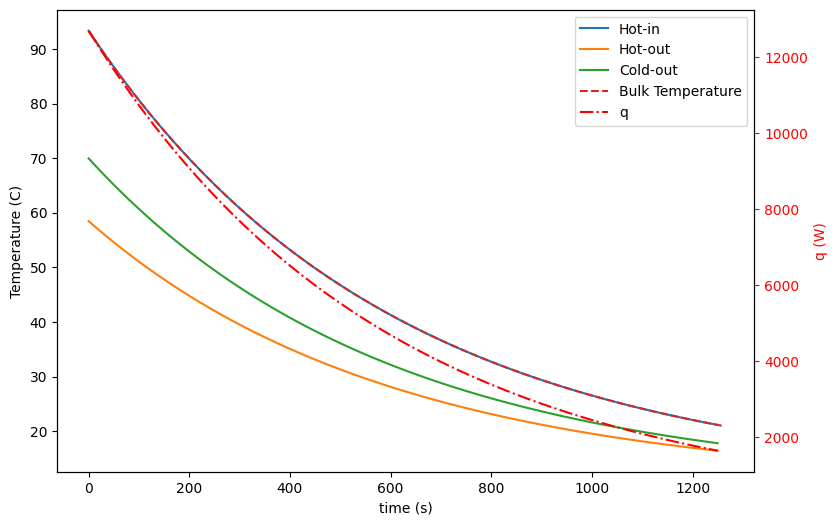

In [123]:
# decrease the diameters
D_i_small = 0.5  # cm
D_o_small = 0.8  # cm
D_i_small = cm_to_m(D_i_small)
D_o_small = cm_to_m(D_o_small)
D_h_out = D_o_small - (D_i_small + 2 * thickness)
A_in = math.pi * (D_i_small ** 2) / 4
A_out = math.pi * ((D_o_small ** 2) / 4 - ((D_i_small + 2 * thickness) ** 2) / 4)

# Run heat transfer and plotting functions
m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.213 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2132 kg/s
Epsilon: 0.58125
Heat rate: 17650.06 W
T_hot_out: 44.9 C
T_cold_out: 29.7 C
T_wort: 91.4 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2132 kg/s
Epsilon: 0.58129
Heat rate: 17239.02 W
T_hot_out: 44.1 C
T_cold_out: 29.3 C
T_wort: 89.6 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2132 kg/s
Epsilon: 0.58131
Heat rate: 16837.69 W
T_hot_out: 43.3 C
T_cold_out: 28.8 C
T_wort: 87.7 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.2132 kg/s
Epsilon: 0.58132
Heat rate: 16445.83 W
T_hot_out: 42.6 C
T_cold_out: 28.4 C
T_wort: 86.0 C

time

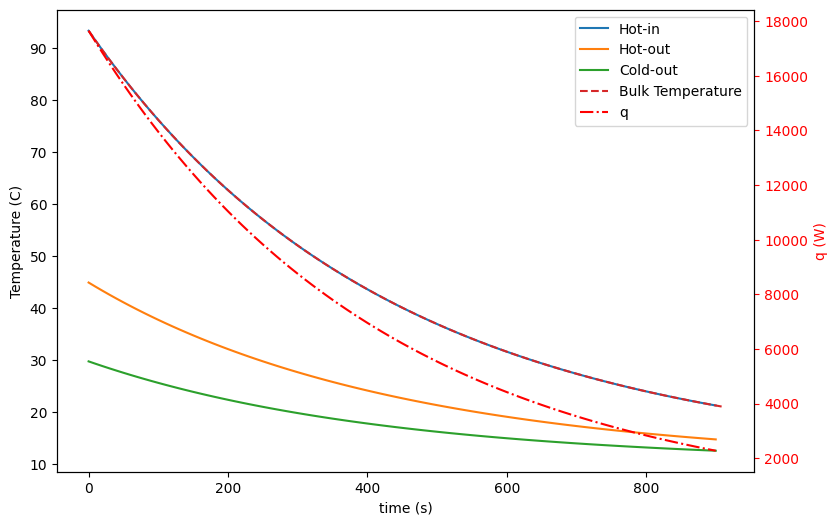

In [124]:
# increase the diameters
D_i_large = 1.2  # cm
D_o_large = 1.6  # cm
D_i_large = cm_to_m(D_i_large)
D_o_large = cm_to_m(D_o_large)
D_h_out = D_o_large - (D_i_large + 2 * thickness)
A_in = math.pi * (D_i_large ** 2) / 4
A_out = math.pi * ((D_o_large ** 2) / 4 - ((D_i_large + 2 * thickness) ** 2) / 4)

# Run heat transfer and plotting functions
m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

## Trying Multiple Pumps

### Pump 1 - 6R

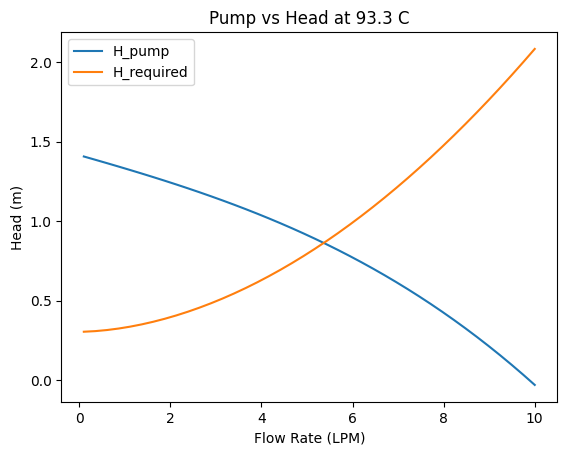

Flow Rate (inner): 0.000089 m^3/s (5.37 LPM)
Mean Velocity: 1.78 m/s
Mass Flow: 0.086


In [125]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

# plot the head curves and calculate flow rate of inner stream
rho_in_0 = get_rho(T_0_wort)
inner_flow = plot_hreq_vs_pump(T_0_wort, pump1)
v_in = inner_flow / A_in
m_dot_in = inner_flow * rho_in_0
print(f"Flow Rate (inner): {inner_flow:.6f} m^3/s ({(inner_flow * 60_000):.2f} LPM)")
print(f"Mean Velocity: {v_in:.2f} m/s")
print(f"Mass Flow: {m_dot_in:.3f}")

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56033
Heat rate: 17014.95 W
T_hot_out: 46.6 C
T_cold_out: 36.3 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56038
Heat rate: 16633.25 W
T_hot_out: 45.8 C
T_cold_out: 35.7 C
T_wort: 89.7 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56041
Heat rate: 16260.23 W
T_hot_out: 45.0 C
T_cold_out: 35.1 C
T_wort: 87.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15895.69 W
T_hot_out: 44.3 C
T_cold_out: 34.5 C
T_wort: 86.2 C

time

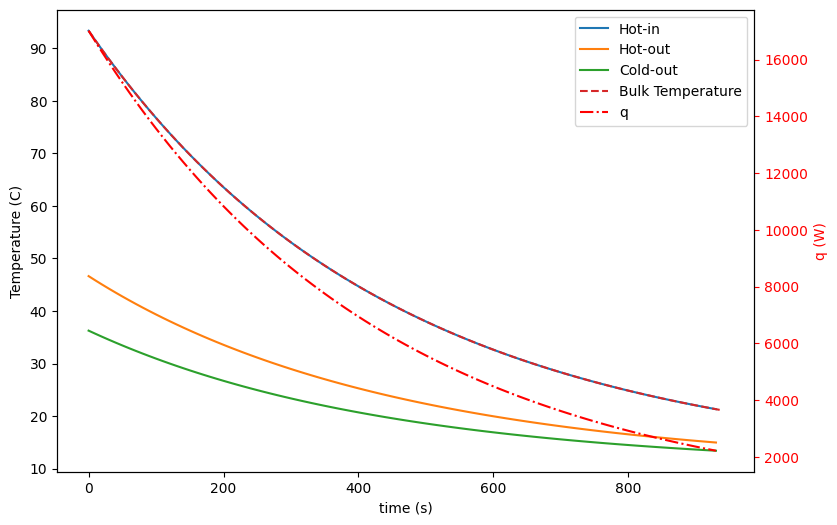

In [126]:
m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

### Pump 2 - 6RZ

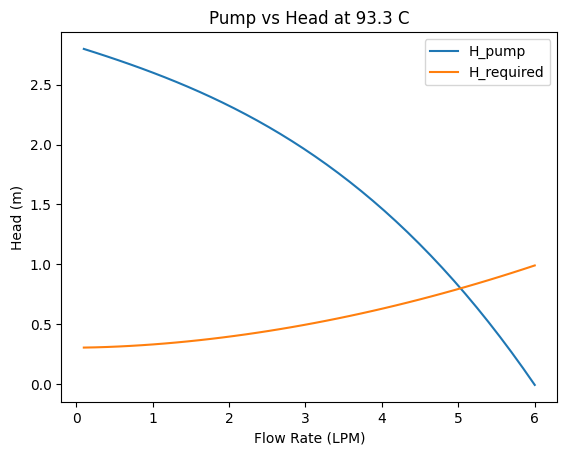

Flow Rate (inner): 0.000084 m^3/s (5.03 LPM)
Mean Velocity: 1.67 m/s
Mass Flow: 0.081


In [127]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

# plot the head curves and calculate flow rate of inner stream
rho_in_0 = get_rho(T_0_wort)
inner_flow = plot_hreq_vs_pump(T_0_wort, pump2)
v_in = inner_flow / A_in
m_dot_in = inner_flow * rho_in_0
print(f"Flow Rate (inner): {inner_flow:.6f} m^3/s ({(inner_flow * 60_000):.2f} LPM)")
print(f"Mean Velocity: {v_in:.2f} m/s")
print(f"Mass Flow: {m_dot_in:.3f}")

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0807 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.58518
Heat rate: 16652.65 W
T_hot_out: 44.6 C
T_cold_out: 35.7 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0808 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.58500
Heat rate: 16290.30 W
T_hot_out: 43.8 C
T_cold_out: 35.1 C
T_wort: 89.8 C

time: 20 s
Mass flow (inner): 0.0808 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.58480
Heat rate: 15935.87 W
T_hot_out: 43.1 C
T_cold_out: 34.6 C
T_wort: 88.1 C

time: 30 s
Mass flow (inner): 0.0809 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.58459
Heat rate: 15589.20 W
T_hot_out: 42.4 C
T_cold_out: 34.1 C
T_wort: 86.4 C

time

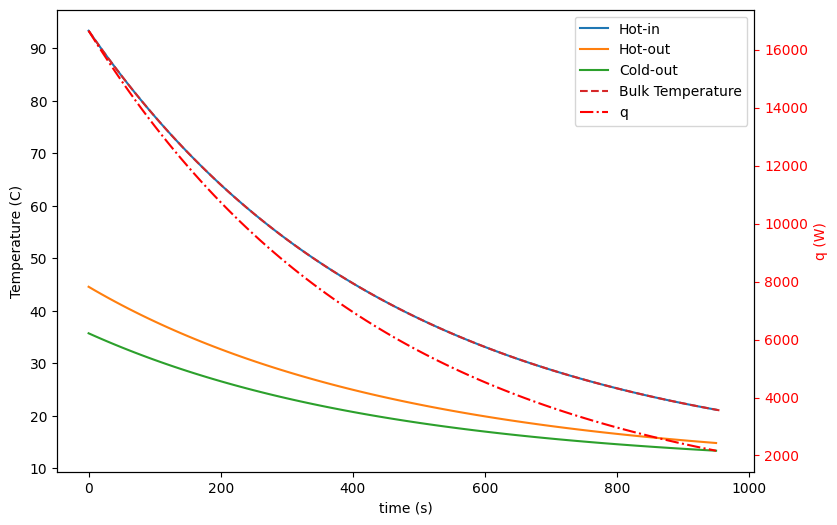

In [128]:
m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump2)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

### Pump 3 - 10 R

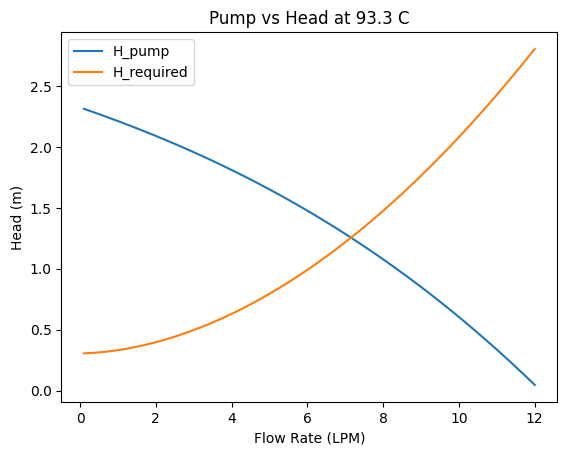

Flow Rate (inner): 0.000119 m^3/s (7.15 LPM)
Mean Velocity: 2.37 m/s
Mass Flow: 0.115


In [129]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

# plot the head curves and calculate flow rate of inner stream
rho_in_0 = get_rho(T_0_wort)
inner_flow = plot_hreq_vs_pump(T_0_wort, pump3)
v_in = inner_flow / A_in
m_dot_in = inner_flow * rho_in_0
print(f"Flow Rate (inner): {inner_flow:.6f} m^3/s ({(inner_flow * 60_000):.2f} LPM)")
print(f"Mean Velocity: {v_in:.2f} m/s")
print(f"Mass Flow: {m_dot_in:.3f}")

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.1147 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45571
Heat rate: 18439.78 W
T_hot_out: 55.4 C
T_cold_out: 38.5 C
T_wort: 91.3 C

time: 10 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45571
Heat rate: 17992.40 W
T_hot_out: 54.3 C
T_cold_out: 37.8 C
T_wort: 89.4 C

time: 20 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45569
Heat rate: 17555.92 W
T_hot_out: 53.2 C
T_cold_out: 37.1 C
T_wort: 87.5 C

time: 30 s
Mass flow (inner): 0.1149 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45566
Heat rate: 17130.10 W
T_hot_out: 52.2 C
T_cold_out: 36.4 C
T_wort: 85.7 C

time

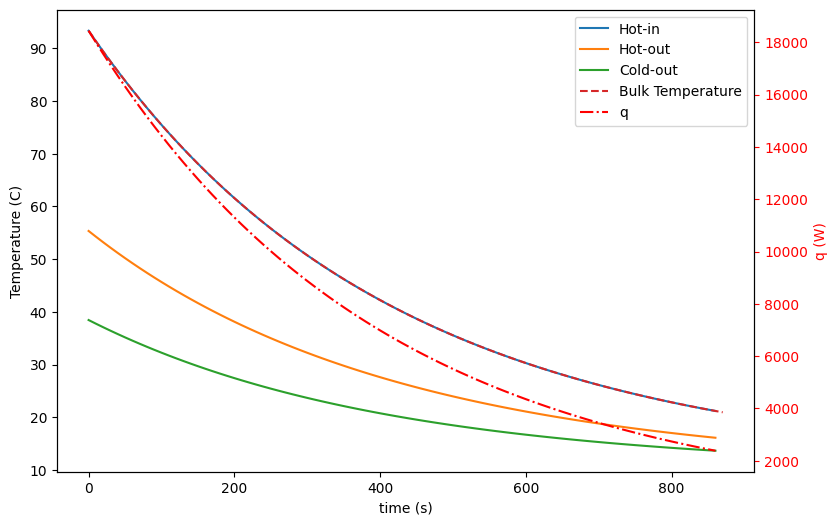

In [130]:
m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump3)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

## Other Relations
Increasing Nusselt number, changing heat exchanger length, pipe material

In [141]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.36938
Heat rate: 11216.52 W
T_hot_out: 62.6 C
T_cold_out: 27.3 C
T_wort: 92.1 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.36940
Heat rate: 11050.52 W
T_hot_out: 61.8 C
T_cold_out: 27.1 C
T_wort: 90.9 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.36941
Heat rate: 10886.98 W
T_hot_out: 61.0 C
T_cold_out: 26.8 C
T_wort: 89.8 C

time: 30 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.36941
Heat rate: 10725.85 W
T_hot_out: 60.3 C
T_cold_out: 26.6 C
T_wort: 88.6 C

time

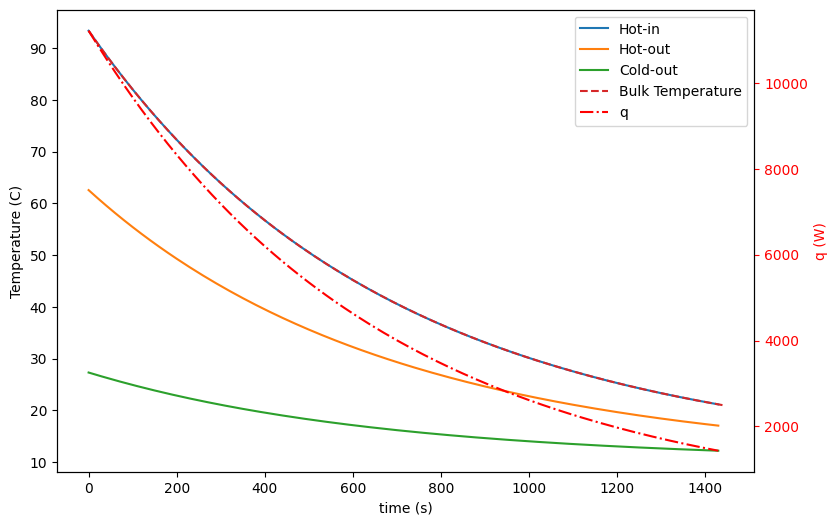

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56033
Heat rate: 17014.95 W
T_hot_out: 46.6 C
T_cold_out: 36.3 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56038
Heat rate: 16633.25 W
T_hot_out: 45.8 C
T_cold_out: 35.7 C
T_wort: 89.7 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56041
Heat rate: 16260.23 W
T_hot_out: 45.0 C
T_cold_out: 35.1 C
T_wort: 87.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15895.69 W
T_hot_out: 44.3 C
T_cold_out: 34.5 C
T_wort: 86.2 C

time

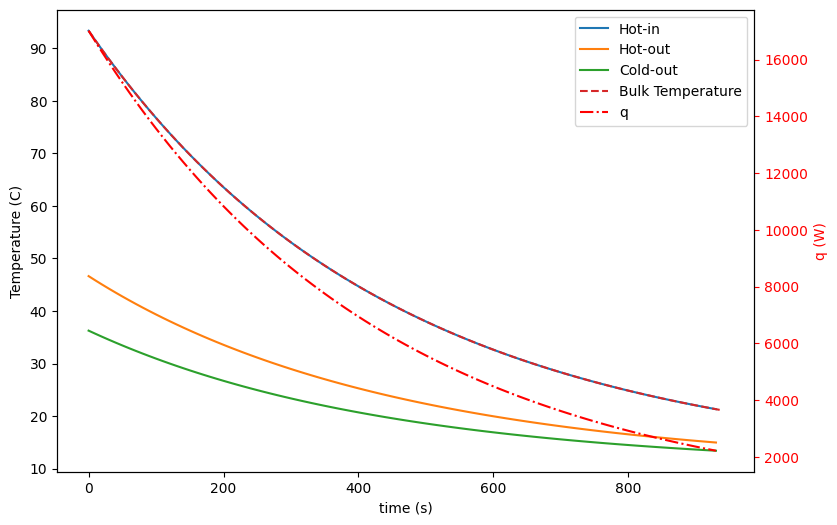

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.74987
Heat rate: 22770.46 W
T_hot_out: 30.8 C
T_cold_out: 45.2 C
T_wort: 90.9 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.74996
Heat rate: 22087.18 W
T_hot_out: 30.2 C
T_cold_out: 44.1 C
T_wort: 88.5 C

time: 20 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.75003
Heat rate: 21424.98 W
T_hot_out: 29.6 C
T_cold_out: 43.1 C
T_wort: 86.2 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.75007
Heat rate: 20783.18 W
T_hot_out: 29.0 C
T_cold_out: 42.1 C
T_wort: 83.9 C

time

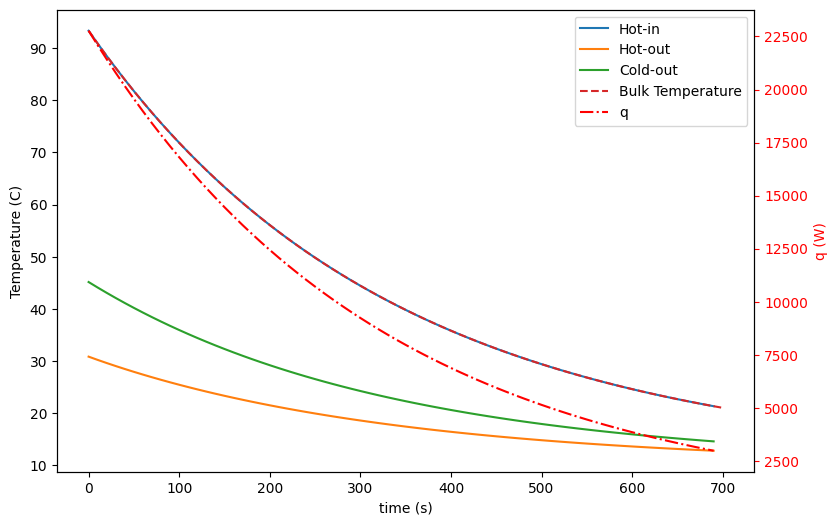

In [138]:
# Vary Nu
Nusselts = [25, 50, 100]
for Nu in Nusselts:
    # solve
    m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
    plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
    plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

In [ ]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

Starting with f_guess = 0.04, v_out = 4.110020274426887

Update Loop:
1: f = 0.03195284635693489, v = 4.598531696595721
2: f = 0.030962928539972404, v = 4.671463336279865

Converged in 2 iterations
Friction Factor: 0.03096
Reynolds Number: 10611.0, flow is Turbulent
Mean Velocity: 4.67 m/s
Mass Flow: 0.231 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2310 kg/s
Epsilon: 0.37328
Heat rate: 11335.08 W
T_hot_out: 62.2 C
T_cold_out: 21.7 C
T_wort: 92.1 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2310 kg/s
Epsilon: 0.37330
Heat rate: 11165.52 W
T_hot_out: 61.5 C
T_cold_out: 21.5 C
T_wort: 90.9 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2310 kg/s
Epsilon: 0.37331
Heat rate: 10998.49 W
T_hot_out: 60.7 C
T_cold_out: 21.3 C
T_wort: 89.7 C

time: 30 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.2310 kg/s
Epsilon: 0.37332
Heat rate: 10833.95 W
T_hot_out: 60.0 C
T_cold_out: 21.2 C
T_wort: 88.5 C

time

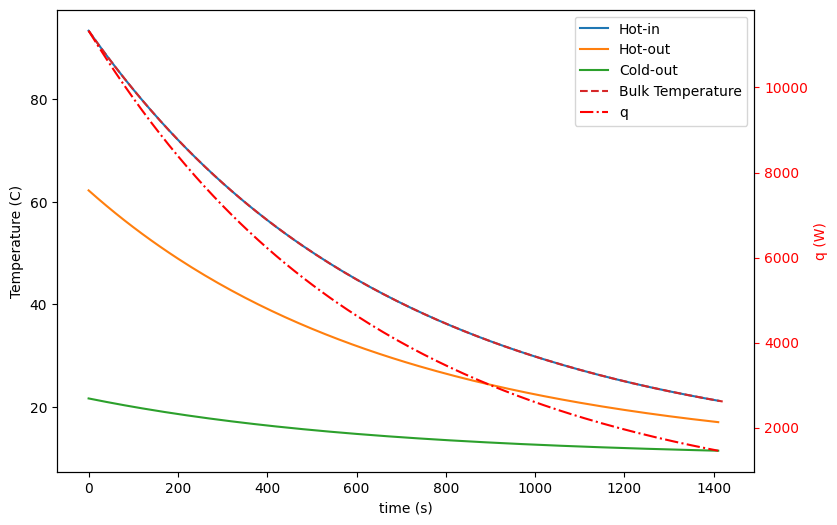

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56033
Heat rate: 17014.95 W
T_hot_out: 46.6 C
T_cold_out: 36.3 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56038
Heat rate: 16633.25 W
T_hot_out: 45.8 C
T_cold_out: 35.7 C
T_wort: 89.7 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56041
Heat rate: 16260.23 W
T_hot_out: 45.0 C
T_cold_out: 35.1 C
T_wort: 87.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15895.69 W
T_hot_out: 44.3 C
T_cold_out: 34.5 C
T_wort: 86.2 C

time

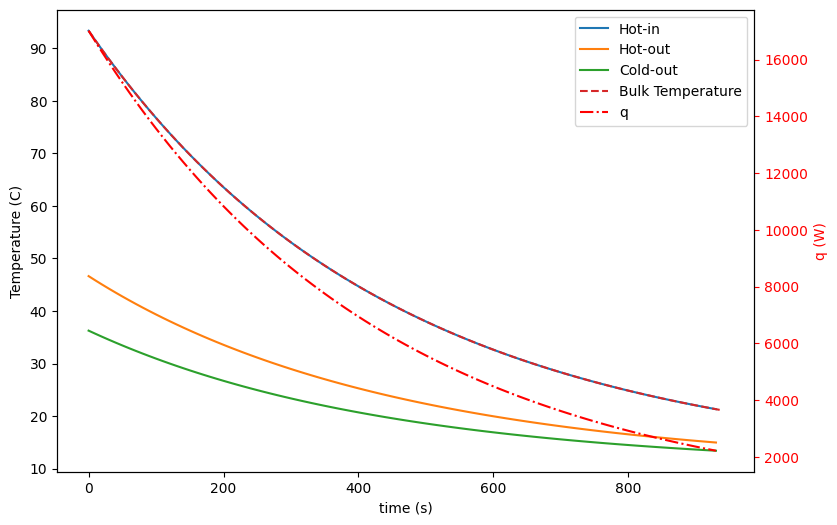

Starting with f_guess = 0.04, v_out = 2.0550101372134435

Update Loop:
1: f = 0.039263031585861384, v = 2.0742067800420667

Converged in 1 iterations
Friction Factor: 0.03926
Reynolds Number: 4741.9, flow is Turbulent
Mean Velocity: 2.07 m/s
Mass Flow: 0.103 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1026 kg/s
Epsilon: 0.70382
Heat rate: 21371.96 W
T_hot_out: 34.7 C
T_cold_out: 59.6 C
T_wort: 91.0 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1026 kg/s
Epsilon: 0.70394
Heat rate: 20771.14 W
T_hot_out: 34.0 C
T_cold_out: 58.2 C
T_wort: 88.8 C

time: 20 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1026 kg/s
Epsilon: 0.70403
Heat rate: 20187.63 W
T_hot_out: 33.3 C
T_cold_out: 56.9 C
T_wort: 86.6 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1026 kg/s
Epsilon: 0.70411
Heat rate: 19620.90 W
T_hot_out: 32.7 C
T_cold_out: 55.6 C
T_wort: 84.5 C

time: 40 s
Mass flow (inner): 0.0862 kg/s
Mass flow (

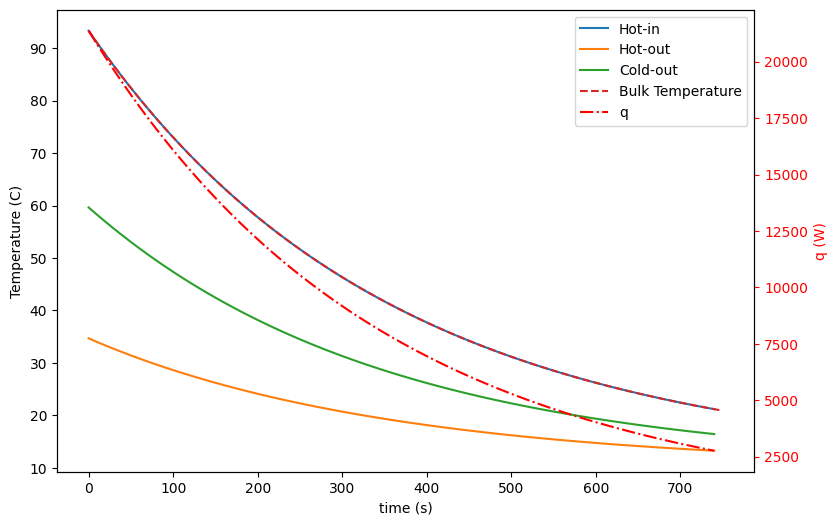

In [142]:
# vary L
Ls = [4, 8, 16]
for length in Ls:
    # solve
    m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
    plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
    plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

In [143]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.1147 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.44053
Heat rate: 17825.37 W
T_hot_out: 56.6 C
T_cold_out: 37.5 C
T_wort: 91.4 C

time: 10 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.44053
Heat rate: 17407.51 W
T_hot_out: 55.5 C
T_cold_out: 36.9 C
T_wort: 89.5 C

time: 20 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.44052
Heat rate: 16999.49 W
T_hot_out: 54.5 C
T_cold_out: 36.2 C
T_wort: 87.7 C

time: 30 s
Mass flow (inner): 0.1149 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.44049
Heat rate: 16601.11 W
T_hot_out: 53.5 C
T_cold_out: 35.6 C
T_wort: 85.9 C

time

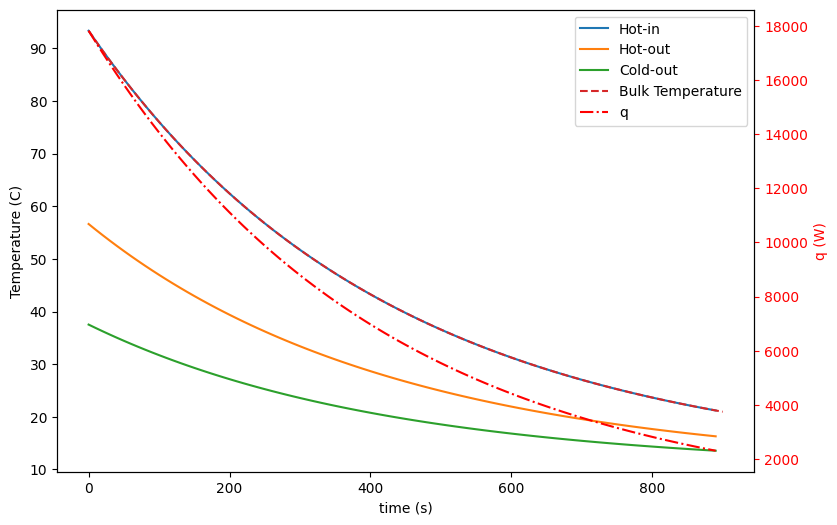

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.1147 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45571
Heat rate: 18439.78 W
T_hot_out: 55.4 C
T_cold_out: 38.5 C
T_wort: 91.3 C

time: 10 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45571
Heat rate: 17992.40 W
T_hot_out: 54.3 C
T_cold_out: 37.8 C
T_wort: 89.4 C

time: 20 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45569
Heat rate: 17555.92 W
T_hot_out: 53.2 C
T_cold_out: 37.1 C
T_wort: 87.5 C

time: 30 s
Mass flow (inner): 0.1149 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.45566
Heat rate: 17130.10 W
T_hot_out: 52.2 C
T_cold_out: 36.4 C
T_wort: 85.7 C

time

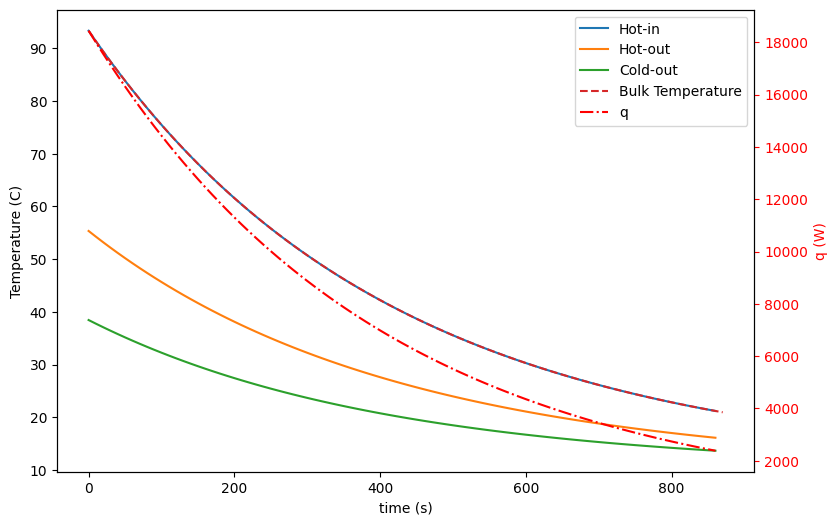

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.1147 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.46370
Heat rate: 18763.07 W
T_hot_out: 54.7 C
T_cold_out: 39.0 C
T_wort: 91.3 C

time: 10 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.46370
Heat rate: 18299.74 W
T_hot_out: 53.6 C
T_cold_out: 38.2 C
T_wort: 89.3 C

time: 20 s
Mass flow (inner): 0.1148 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.46367
Heat rate: 17847.90 W
T_hot_out: 52.5 C
T_cold_out: 37.6 C
T_wort: 87.4 C

time: 30 s
Mass flow (inner): 0.1149 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.46363
Heat rate: 17407.29 W
T_hot_out: 51.5 C
T_cold_out: 36.9 C
T_wort: 85.5 C

time

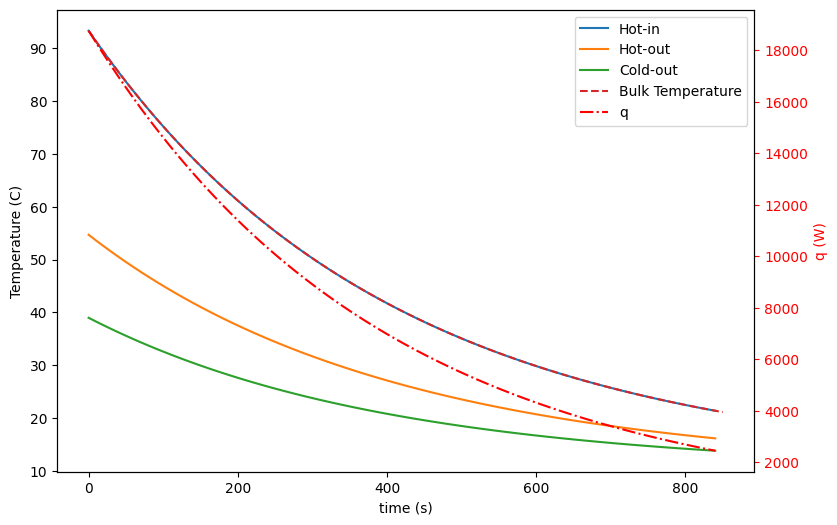

In [144]:
# vary k_tube
ks_tube = [7.5, 15, 30]
for k_tube in ks_tube:
    # solve
    m_dot_out, _, _, _ = outer_flow(P_water, 0.04)
    plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump3)
    plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)

# Final Results

Starting with the properties and dimensions given

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56033
Heat rate: 17014.95 W
T_hot_out: 46.6 C
T_cold_out: 36.3 C
T_wort: 91.5 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56038
Heat rate: 16633.25 W
T_hot_out: 45.8 C
T_cold_out: 35.7 C
T_wort: 89.7 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56041
Heat rate: 16260.23 W
T_hot_out: 45.0 C
T_cold_out: 35.1 C
T_wort: 87.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.1544 kg/s
Epsilon: 0.56043
Heat rate: 15895.69 W
T_hot_out: 44.3 C
T_cold_out: 34.5 C
T_wort: 86.2 C

time

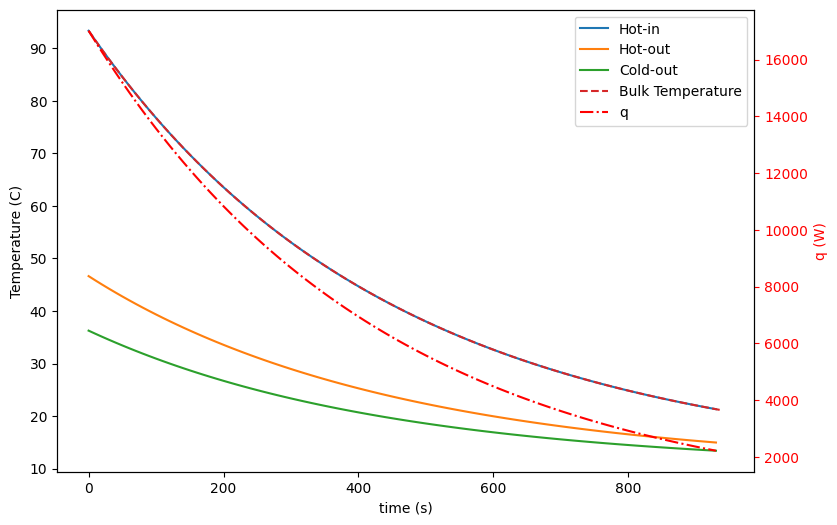

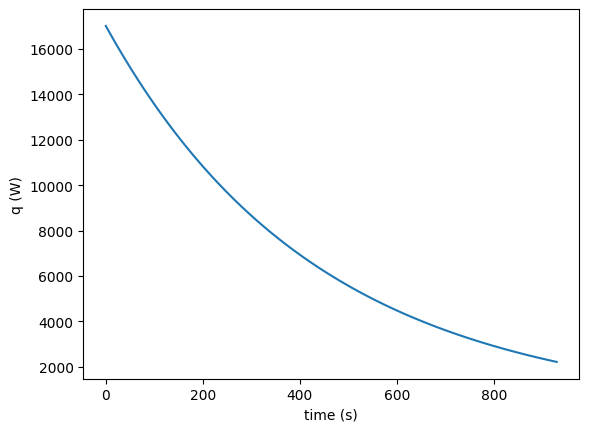

In [135]:
delta_h, thickness, D_i, D_o, V_wort, T_0_wort, T_f_wort, T_city, P_water, D_h_out, A_in, A_out, rho_city, mu_city, length, minor_losses, k_tube, Nu, P_atm, g = load_default_values()

# Get city water flow properties
m_dot_out, v_out, Re_out, f_out = outer_flow(P_water, 0.04)

# Run heat transfer and plotting functions
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)
plot_q(plot_times[:-1], q)

## Better Performance with Decreased City Pressure

Starting with f_guess = 0.04, v_out = 1.4068965748281952

Update Loop:
1: f = 0.04437025860377783, v = 1.3358146066956067
2: f = 0.045145881030793256, v = 1.3242900060462635

Converged in 2 iterations
Friction Factor: 0.04515
Reynolds Number: 3082.3, flow is Laminar
Mean Velocity: 1.32 m/s
Mass Flow: 0.065 kg/s
Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61401
Heat rate: 14064.21 W
T_hot_out: 54.7 C
T_cold_out: 61.2 C
T_wort: 91.8 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61386
Heat rate: 13804.46 W
T_hot_out: 53.9 C
T_cold_out: 60.2 C
T_wort: 90.3 C

time: 20 s
Mass flow (inner): 0.0861 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61372
Heat rate: 13549.56 W
T_hot_out: 53.1 C
T_cold_out: 59.3 C
T_wort: 88.9 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Mass flow (outer): 0.0655 kg/s
Epsilon: 0.61356
Heat rate: 13299.42 W
T_hot_out: 52.3 C
T_cold_out: 58.4 C
T_wort: 87.4 C

time

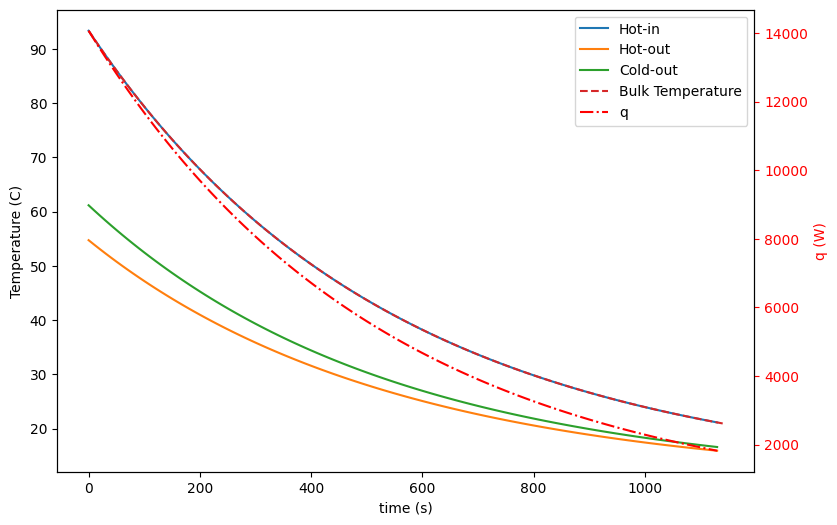

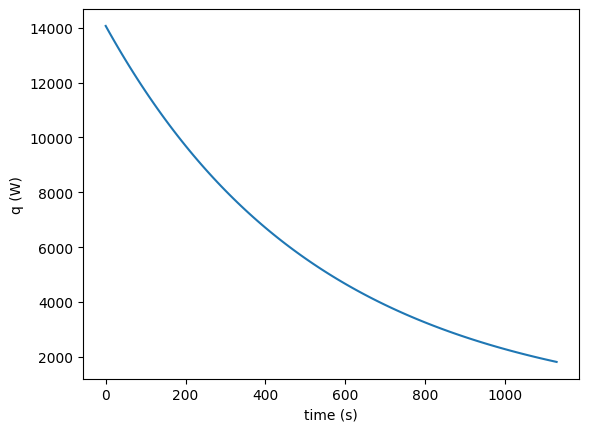

In [136]:
# Change city water pressure to improve performance
P_water = psi_to_pa(30)

# Get city water flow properties
m_dot_out, v_out, Re_out, f_out = outer_flow(P_water, 0.04)

# Run heat transfer and plotting functions
plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, time, water_used, q = heat_transfer_loop(10, m_dot_out, pump1)
plot_stream_temps(plot_times, hot_temps_in, hot_temps_out, cold_temps_out, wort_temps, q, time)
plot_q(plot_times[:-1], q)